<a href="https://colab.research.google.com/github/divyasingh2611/Next-word-prediction-using-lstm/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import string

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NextWord Predictor using LSTM/medium_data.csv")
data.head()

,id,url,title,subtitle,image,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/a-beginners-gui...,A Beginner’s Guide to Word Embedding with Gens...,NaN,1.png,850,8,8,Towards Data Science,2019-05-30
1,2,https://towardsdatascience.com/hands-on-graph-...,Hands-on Graph Neural Networks with PyTorch & ...,NaN,2.png,1100,11,9,Towards Data Science,2019-05-30
2,3,https://towardsdatascience.com/how-to-use-ggpl...,How to Use ggplot2 in Python,A Grammar of Graphics for Python,3.png,767,1,5,Towards Data Science,2019-05-30
3,4,https://towardsdatascience.com/databricks-how-...,Databricks: How to Save Files in CSV on Your L...,When I work on Python projects dealing…,4.jpeg,354,0,4,Towards Data Science,2019-05-30
4,5,https://towardsdatascience.com/a-step-by-step-...,A Step-by-Step Implementation of Gradient Desc...,One example of building neural…,5.jpeg,211,3,4,Towards Data Science,2019-05-30


In [ ]:
data['publication'].value_counts()

publication
The Startup                3041
Towards Data Science       1461
Data Driven Investor        778
UX Collective               555
The Writing Cooperative     403
Better Marketing            242
Better Humans                28
Name: count, dtype: int64

In [ ]:
data.shape

(6508, 10)

In [ ]:
data['title']

0       A Beginner’s Guide to Word Embedding with Gens...
1       Hands-on Graph Neural Networks with PyTorch & ...
2                            How to Use ggplot2 in Python
3       Databricks: How to Save Files in CSV on Your L...
4       A Step-by-Step Implementation of Gradient Desc...
                              ...                        
6503    “We” vs “I” — How Should You Talk About Yourse...
6504                     How Donald Trump Markets Himself
6505        Content and Marketing Beyond Mass Consumption
6506    5 Questions All Copywriters Should Ask Clients...
6507               How To Write a Good Business Blog Post
Name: title, Length: 6508, dtype: object

In [ ]:
data['title'][0]

'A Beginner’s Guide to Word Embedding with Gensim Word2Vec\xa0Model'

# Preprocess the Data
for removing unnecassary character from the text

In [ ]:
def clean_text(text):

  # Convert to lowercase
  text = text.lower()

  # Remove punctuation
  #text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)

  # Replace specific Unicode spaces with regular spaces
  text = text.replace(u'\xa0', u' ').replace(u'\u200a', u' ')

  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text).strip()



  return text




In [ ]:
# Apply the preprocess_text function to the 'text' column
data['title'] = data['title'].apply(clean_text)

In [ ]:
data['title'][0]

'a beginner’s guide to word embedding with gensim word2vec model'

In [ ]:
data['title']

0       a beginner’s guide to word embedding with gens...
1       hands-on graph neural networks with pytorch & ...
2                            how to use ggplot2 in python
3       databricks: how to save files in csv on your l...
4       a step-by-step implementation of gradient desc...
                              ...                        
6503    “we” vs “i” — how should you talk about yourse...
6504                     how donald trump markets himself
6505        content and marketing beyond mass consumption
6506    5 questions all copywriters should ask clients...
6507               how to write a good business blog post
Name: title, Length: 6508, dtype: object

# Tokenizer

The Keras Tokenizer class allows you to vectorize a text corpus by converting each word (or token) into an integer index.         
"ovv" -- stands for "out-of-vocabulary" token and is used to handle words that were not seen during the training of the tokenizer


In [ ]:
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(data['title'])
total_words = len(tokenizer.word_index) + 1

In [ ]:
total_words

8238

In [ ]:
print("<oov>: ", tokenizer.word_index['<oov>'])
print("Strong: ", tokenizer.word_index['strong'])
print("Data: ", tokenizer.word_index['data'])

<oov>:  1
Strong:  4
Data:  17


In [ ]:
input_sequences = []
for line in data['title']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #print(token_list)

    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

Total input sequences:  48461


# Padding

Padding in LSTM (Long Short-Term Memory) networks is used to ensure that all sequences in a batch have the same length. This is necessary because neural networks expect inputs to be of uniform size.

In [ ]:
max_length = max([len(x) for x in input_sequences])
max_length

40

In [ ]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=40,padding='pre'))
input_sequences[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 676,
        68], dtype=int32)

Making a supervised learning model- we consider last element of all sequences as a label

In [ ]:
# create features and label
x,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Bi- LSTM Mdoel

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=39))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x, ys, epochs=50, verbose=1)
#print model.summary()
print(model)

Epoch 1/50
1515/1515 [==============================] - 273s 177ms/step - loss: 6.9944 - accuracy: 0.0824
Epoch 2/50
1515/1515 [==============================] - 267s 176ms/step - loss: 6.1830 - accuracy: 0.1381
Epoch 3/50
1515/1515 [==============================] - 267s 176ms/step - loss: 5.6607 - accuracy: 0.1680
Epoch 4/50
1515/1515 [==============================] - 270s 178ms/step - loss: 5.1866 - accuracy: 0.1925
Epoch 5/50
1515/1515 [==============================] - 270s 178ms/step - loss: 4.7444 - accuracy: 0.2156
Epoch 6/50
1515/1515 [==============================] - 272s 180ms/step - loss: 4.3252 - accuracy: 0.2430
Epoch 7/50
1515/1515 [==============================] - 271s 179ms/step - loss: 3.9326 - accuracy: 0.2822
Epoch 8/50
1515/1515 [==============================] - 268s 177ms/step - loss: 3.5577 - accuracy: 0.3309
Epoch 9/50
1515/1515 [==============================] - 261s 172ms/step - loss: 3.2099 - accuracy: 0.3832
Epoch 10/50
1515/1515 [=======================

# Accuracy and loss plots

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

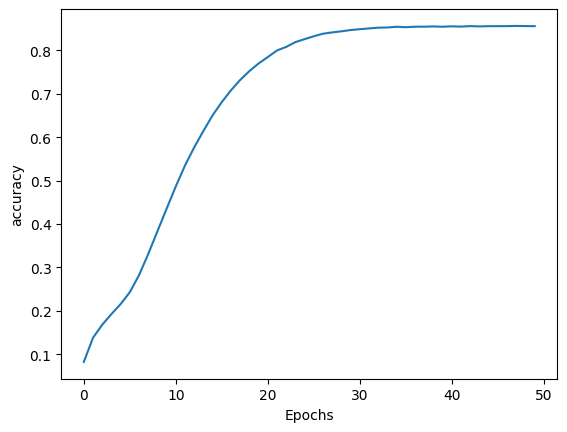

In [ ]:
plot_graphs(history, 'accuracy')

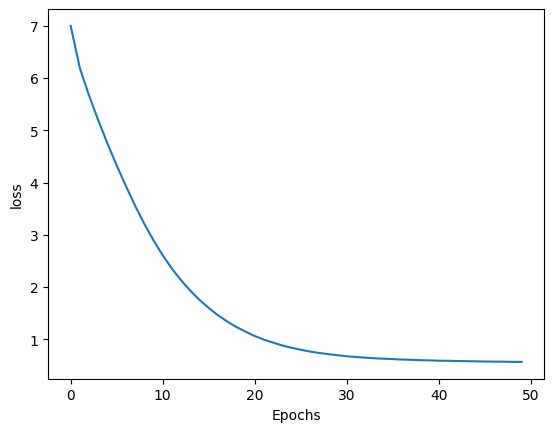

In [ ]:
plot_graphs(history, 'loss')

# Predicting next word

In [ ]:
seed_text = "Hands on"
next_words = 7

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_length-1, padding='pre')


     # Use predict to get the probabilities
    predicted_probabilities = model.predict(token_list, verbose=0)
    predicted = np.argmax(predicted_probabilities)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Hands on graph neural networks with pytorch pytorch geometric
